In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from scipy.signal import convolve, gaussian
import time
# import ipdb

ModuleNotFoundError: No module named 'ipdb'


## EXP 1: Acquisition and Extinction


In [4]:
class Purkinje(object):
    def __init__(self):
        
        self.R_max  = 1.0
        self.R_production_rate = .0001
        self.V_hyp = -85
        self.V_rest = -70
        self.V_thresh = -54
        self.V_spike = 10
        self.tau_m = 5
        self.tau_e = 1
        self.tau_i = 2
        self.tau_j1 = 90# Smaller: faster recovery --> later trigger --> earlier pause. Larger: slower recovery --> earlier trigger --> later pause
        self.tau_j2 = 200
        self.tau_r = 100
        self.s = 0.0
        self.J1_0 = 2.0
        self.J2_0 = 2.0
        self.J1_thresh = 0.0
        self.J2_thresh = 0.0
        self.c = 0.01
        self.evolution_noise = 10.0
        self.a = 2000 #2000
        self.write_ref_counter_max = 2000
        self.read_ref_counter_max = 2000
        self.mu = 10
        self.sigma=5
        self.max_ISI = 1800        
    
        self.all_R  = []
        self.all_P = []
        self.all_V = []
        self.all_I = []
        self.all_E = []
        self.all_H = []
        self.all_J1 = []
        self.all_J2 = []
        self.all_CS = []
        self.all_US = []
                      
        self.all_rasters = []

        self.H = np.zeros((self.max_ISI,))

        
    def V_step(self,V, E, I, P):
        delta = -1*(1. / self.tau_m) * (V - self.V_rest) + E - I + P
        return V + delta

    def E_step(self,E, CS):
        delta = -1*(1 / self.tau_e)*E + self.s*CS
        return E + delta

    def I_step(self,I, h):
        delta = -1*(1 / self.tau_i) * I + h
        return I + delta

    def J1_step(self,J1, CS):
        # TODO: Check
        delta = (1/self.tau_j1)*(self.J1_0 - J1) - CS
        return J1 + delta

    def J2_step(self,J2, CS):
        # TODO: Check
        delta = (1/self.tau_j2)*(self.J2_0 - J2) - CS
        return J2 + delta
    
    def run(self,trials=100, ITI=5.0, CS_onsets=[0.001], CS_offsets=[.5], US_onsets=[1.5],
            US_offsets=[1.6], CS_freq=100, US_freq = 500, probe_start=75, probe_per=5,
            multiple=False,verbose=False):
        
        CS_onsets  = [1000*CSon for CSon in CS_onsets]
        CS_offsets  = [1000*CSoff for CSoff in CS_offsets]
        US_onsets  = [1000*USon for USon in US_onsets]
        US_offsets = [1000*USoff for USoff in US_offsets]
        ITI       = int(1000*ITI)
        
        kernel = gaussian(99, self.sigma)
        kernel /= kernel.sum()
        # Initialize
        V = self.V_rest
        E = 0
        I = 0
        J1 = self.J1_0
        J2 = self.J1_0
        R = self.R_max
        write_ref_counter = 0
        read_ref_counter = 0
        US_flag = False
        writing = False
        reading = False
        batch_writing = np.zeros((self.max_ISI,))
        spiked=False

        for i in range(trials):
            if verbose:
                print('Trial {}'.format(i))
                
            if multiple:
                trial_CS_onsets = [CS_onsets[i % len(CS_onsets)]]
                trial_CS_offsets = [CS_offsets[i % len(CS_offsets)]]
                trial_US_onsets = [US_onsets[i % len(US_onsets)]]
                trial_US_offsets = [US_offsets[i % len(US_offsets)]]
            else:
                trial_CS_onsets = CS_onsets
                trial_CS_offsets = CS_offsets
                trial_US_onsets = US_onsets
                trial_US_offsets = US_offsets
                
            CS_intervals = []
            for c in range(len(trial_CS_onsets)):
                CS_intervals += range(int(trial_CS_onsets[c]), int(trial_CS_offsets[c]))
                
            US_intervals = []
            if sum(trial_US_onsets) < np.inf and sum(trial_US_offsets) < np.inf:
                for u in range(len(trial_US_onsets)):
                    US_intervals += range(int(trial_US_onsets[u]), int(trial_US_offsets[u]))

            raster = []
            all_CS = []
            trial_R  = []
            trial_P = []
            trial_V = []
            trial_I = []
            trial_E = []
            trial_H = []
            trial_J1 = []
            trial_J2 = []
            trial_CS = []
            trial_US = []
            trial_rasters = []
            trial_h = []
            US_detected = False
            for t in range(ITI): 
                if t > probe_start and ((t - probe_start) % probe_per) == 0:
                    probe = True
                else:
                    probe = False
                    
                # Replenish vesicle
                if not writing:
                    R = min(R + self.R_production_rate*self.R_max, self.R_max)
                    R = max(R, 0)
                # Decrement refratory periods
                read_ref_counter = max(read_ref_counter - 1, 0)
                write_ref_counter = max(write_ref_counter - 1, 0)
                
                # Stimuli
                
                if t in CS_intervals:
                    CS = 1*(((t - CS_intervals[0]) % (1000 / CS_freq)) == 0)
                else:
                    CS = 0
                # Stimuli
                if t in US_intervals and not probe:
                    if not US_detected:
                        US_flag = True
                        US_detected = True
                    US = 1*(((t - US_intervals[0]) % (1000 / US_freq)) == 0)
                else:
                    US = 0
                all_CS.append(CS)

                # Update ctivation energy
                J1 = self.J1_step(J1,CS)
                J2 = self.J2_step(J1,CS)
 
                # If writing threshold is met and w-refractory period is over
                if J1 <= self.J1_thresh and write_ref_counter == 0 and len(US_intervals) > 0:
#                     print(t)
                    #Reset refractory period
                    write_ref_counter = self.write_ref_counter_max
                    # Set mode to writing
                    writing = True
                    write_t = t
                    # Initialize writing batch
                    batch_writing = list(np.zeros((self.max_ISI,)))
             
                # If writing 
                if writing:
                    # Sample batch from reserve
                    new_batch = R / self.tau_r
                    R = R - new_batch
                    # Add to evolution
                    batch_writing = [new_batch] + batch_writing[:-1]
                    # Evolution noise
                    batch_writing = list(np.convolve(np.array(batch_writing), kernel, mode='same'))
                # If reading threshold met and r-refractory period is over
                if J2 <= self.J2_thresh and read_ref_counter == 0: 
                    # Reset refractory period
                    read_ref_counter = self.read_ref_counter_max
                    # Turn on reading mode and turn off writing
                    reading = True
                    read_t = t
                    all_h = []
                    read_index = 0
                    # Read batch and decrement archive
                    batch_reading = self.c*self.H
                    self.H -= self.c*self.H
                  
                if reading:
                    h = self.a * batch_reading[read_index]
                    read_index += 1
                    if read_index == len(self.H) - 1:
                        reading = False
                else:
                    h = 0.0

                # At first US spike
                if US_flag:
                    # Stop writing
                    writing=False
                    # Add writing batch to the archive
                    self.H += batch_writing
                    US_flag = False

                # Dynamics
                P = self.mu * (np.random.rand() < .3)
                E = self.E_step(E,CS)
                I = self.I_step(I,h)
                if spiked:
                    V = self.V_hyp
                    spiked=False
                else:
                    V = self.V_step(V,E,I,P)

                if V > self.V_thresh:
                    spiked=True
                    V = self.V_spike
                    raster.append(1)
                else:
                    raster.append(0)
                trial_P.append(P)
                trial_R.append(R)
                trial_I.append(I)
                trial_E.append(E)
                trial_V.append(V)
                trial_J1.append(J1)
                trial_J2.append(J2)
                trial_CS.append(CS)
                trial_US.append(US)
                trial_h.append(h)
# #             if i == 159:
#             plt.plot(self.H)
#             plt.xlim([0,1000])
# #                 plt.ylim([0,.06])
#             plt.show()
#             plt.close()
#             ipdb.set_trace()
            self.all_H.append(self.H)
            self.all_P.append(trial_P)
            self.all_R.append(trial_R)
            self.all_I.append(trial_I)
            self.all_E.append(trial_E)
            self.all_V.append(trial_V)
            self.all_J1.append(trial_J1)
            self.all_J2.append(trial_J2)
            self.all_CS.append(trial_CS)
            self.all_US.append(trial_US)
            self.all_rasters.append(raster)

In [5]:
# Acquisition

acq_trials=400
CS_onsets=[0.0]
CS_offsets=[0.3] #[0.35]
US_onsets=[0.22] #[0.2]
US_offsets=[0.25] #[0.3]
probe_start = 50
probe_per   = 5
ITI=10
CS_freq=50
US_freq = 500

pk = Purkinje()
pk.run(CS_onsets=CS_onsets, CS_offsets=CS_offsets, US_onsets=US_onsets, US_offsets=US_offsets,
       ITI=ITI, CS_freq=CS_freq, US_freq=US_freq,trials=acq_trials, probe_start=probe_start, probe_per=probe_per,
      verbose=0)



In [ ]:
# Extinction
ext_trials=400
# CS_onset= np.infty
# CS_offset =np.infty
ITI=10
CS_freq=50
US_freq = 500

# pk = Purkinje()
pk.run(CS_onsets=CS_onsets, CS_offsets=CS_offsets, US_onsets=[np.infty], US_offsets=[np.infty],
       ITI=ITI, CS_freq=CS_freq, US_freq=US_freq,trials=ext_trials, probe_start=probe_start, probe_per=probe_per,
      verbose=0)

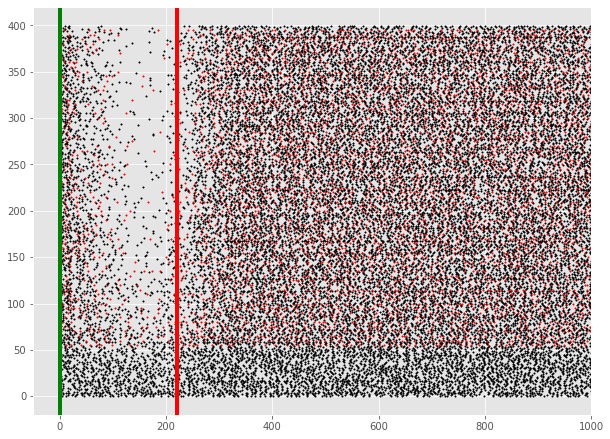

In [6]:
# Rasters

rasters = np.array(pk.all_rasters)
acq_rasters = rasters[:acq_trials,...]
# ext_rasters = rasters[acq_trials:,...]

# for rst in [acq_rasters, ext_rasters]:
for rst in [acq_rasters]:
    fig, ax = plt.subplots(figsize=(10,7.5))
    for i in range(rst.shape[0]):
        if i > probe_start and ((i - probe_start) % probe_per) == 0:
            color = 'r'
        else:
            color = 'k'
        trial = rst[i,...]
        spike_times = np.nonzero(trial)
        plt.scatter(spike_times, i*np.ones_like(spike_times), color=color, s=2)
    # ax.axhline(y=CR_onset, color='b'
    for _ in range(len(CS_onsets)):
        ax.axvline(x=(CS_onsets[_] * 1000), color='g', linewidth=4)
    for _ in range(len(US_onsets)):
        ax.axvline(x=(US_onsets[_] * 1000), color='r', linewidth=4)
    plt.xlim([-50,1000])
    plt.show()
    plt.close()



In [ ]:
# MP after learning
fig, ax = plt.subplots(figsize=(20,7.5))
potential = pk.all_V[acq_trials-1]
ax.plot(potential, color='b')
for _ in range(len(CS_onsets)):
    ax.axvline(x=(CS_onsets[_] * 1000), color='g', linewidth=6)
for _ in range(len(US_onsets)):
    ax.axvline(x=(US_onsets[_] * 1000), color='r', linewidth=6)
plt.xlim([CS_onsets[0] * 1000, US_onsets[0] * 1000 + 1000])
# plt.ylim([-150,50])
plt.show()
plt.close()



In [ ]:
# I after learning
fig, ax = plt.subplots(figsize=(20,7.5))
I = pk.all_I[acq_trials - 1]
ax.plot(I, color='b')
for _ in range(len(CS_onsets)):
    ax.axvline(x=(CS_onsets[_] * 1000), color='g', linewidth=6)
for _ in range(len(US_onsets)):
    ax.axvline(x=(US_onsets[_] * 1000), color='r', linewidth=6)
plt.xlim([CS_onsets[0] * 1000, US_onsets[0] * 1000 + 1000])
# plt.ylim([-100,50])
plt.show()
plt.close()



# EXP 2: Pause stats by ISI¶


In [ ]:
ISIs = np.linspace(.15,.5,4)
# ISIs = [.2]
acq_trials=400
CS_onsets=[1.0]
CS_offsets=[1.35]

probe_start = 50
probe_per   = 5
ITI=10
CS_freq=50
US_freq = 500
exp_rasters = []
exp_Is = []
for ISI in ISIs:
    print('Running ISI: {}'.format(ISI))
    US_onsets=[CS_onsets[0] + ISI]
    US_offsets=[US_onsets[0] + .1]
    pk = Purkinje()
    pk.run(CS_onsets=CS_onsets, CS_offsets=CS_offsets, US_onsets=US_onsets, US_offsets=US_offsets,
           ITI=ITI, CS_freq=CS_freq, US_freq=US_freq,trials=acq_trials, verbose=False)
    exp_rasters.append(pk.all_rasters)
    exp_Is.append(pk.all_I)

Running ISI: 0.15
Running ISI: 0.26666666666666666
Running ISI: 0.3833333333333333


In [ ]:
# Pause stats
all_final_trials = [rst[-2] for rst in exp_rasters]
all_final_I = [I[acq_trials - 1] for I in exp_Is]
base_rate = np.array(exp_rasters[0][0])[:int(CS_onsets[0]*1000)].mean(0) * 1000
kernel_width = 100
pause_onsets = []
pause_max = []
pause_offsets = []

for t, trial in enumerate(all_final_I):
#     ISI_spikes = trial[int(CS_onsets[0] * 1000):int(CS_offsets[0] * 1000) + 300]
#     psth = np.convolve(trial, np.ones(kernel_width)/float(kernel_width), mode='same') * 1000
#     ISI_region = psth[int(CS_onsets[0])*1000 - 500 : int(US_onsets[0])*1000 + 800]

    low    = np.argwhere(trial < .375) - CS_offsets[0]*1000
    if len(low) > 0:
        pause_onsets.append(low[0])
        pause_offsets.append(low[-1])
        pause_max.append(np.argmin(trial))
    else:
        pause_onsets.append(np.nan)
        pause_max.append(np.nan )
        pause_offsets.append(np.nan)     
# ipdb.set_trace()
fig, axes = plt.subplots(1,3,figsize=(12,4))
for ax, nm, arr in zip(axes,['Onsets', 'Offsets', 'Max'],[pause_onsets, pause_offsets, pause_max]):
    ax.scatter(ISIs * 1000, arr)
    ax.plot(ISIs*1000, ISIs*1000,color='b',linewidth=4)
    ax.set_xlabel('ISI')
    ax.set_ylabel('ms since CS')
    ax.set_title(nm)
#     ax.set_ylim([0, max(ISIs.max() * 1000, np.array(arr).max())])
    ax.set_xlim([0,550])
    ax.set_ylim([0,600])
plt.show()
plt.close()

fig, axes = plt.subplots(2,4,figsize=(12,3))
for a, ax in enumerate(axes.reshape(-1)):
    ax.plot(all_final_I[a])
    ax.set_xlim([0,2000])
#     ax.set_ylim([0,5.0])
plt.show()
plt.close()

# Ex. 3 Varying probe


In [ ]:
# Acquisition

trials=100
CS_onsets=[0.0]
CS_offsets=[0.35]
US_onsets=[0.2]
US_offsets=[0.3]
probe_start = 50
probe_per   = 5
ITI=2
CS_freq=50
US_freq = 500

pk = Purkinje()
pk.run(CS_onsets=CS_onsets, CS_offsets=CS_offsets, US_onsets=US_onsets, US_offsets=US_offsets,
       ITI=ITI, CS_freq=CS_freq, US_freq=US_freq,trials=trials, probe_start=probe_start,
       probe_per=probe_per, verbose=0)

probe_CS_offsets = [.1,.55,.05]
probe_CS_freqs   = [50,100,25]

probe_V = []
for CSo in probe_CS_offsets:
    for CSf in probe_CS_freqs:
        pk.run(CS_onsets=CS_onsets, CS_offsets=[CS + CSo for CS in CS_onsets], US_onsets=US_onsets, US_offsets=US_offsets,
       ITI=ITI, CS_freq=CSf, US_freq=US_freq,trials=1, probe_start=0, probe_per=1)
        probe_V.append(pk.all_V[-1])

In [ ]:
fig, axes = plt.subplots(3,3,figsize=(10,10))

counter = 0
for CSo in probe_CS_offsets:
    for CSf in probe_CS_freqs:
        potential = probe_V[counter]
        ax = axes.reshape(-1)[counter]
        ax.plot(potential, color='b')
        ax.axvline(x=(CS_onsets[0] * 1000), color='g', linewidth=3)
        ax.axvline(x=((CS_onsets[0] + CSo) * 1000), color='g', linewidth=3)
        ax.axvline(x=(US_onsets[0] * 1000), color='r', linewidth=3)
        ax.set_xlim([CS_onsets[0] * 1000, US_onsets[0] * 1000 + 500])
        ax.set_ylim([-150,25])
        counter += 1
        
for a, ax in enumerate(axes[0,:]):
    ax.set_title('CS frequency: {} Hz'.format(probe_CS_freqs[a]))
    
for a, ax in enumerate(axes[:,0]):
    ax.set_ylabel('CS duration: {} s'.format(probe_CS_offsets[a]), fontweight='bold', fontsize=14)
    
plt.show()
plt.close()



# Ex. 4 Double pause

In [ ]:
# Acquisition

trials=400
CS_onsets=[0.0]
CS_offsets=[.25]
US_onsets=[.2,.5]
US_offsets=[.3,.6]
probe_start = 50
probe_per   = 5
ITI=15
CS_freq=50
US_freq = 500

pk = Purkinje()
pk.run(CS_onsets=CS_onsets, CS_offsets=CS_offsets, US_onsets=US_onsets, US_offsets=US_offsets,
       ITI=ITI, CS_freq=CS_freq, US_freq=US_freq,trials=trials, probe_start=probe_start,
       probe_per=probe_per, multiple=True, verbose=0)



In [ ]:
# Rasters
raster = np.array(pk.all_rasters)
# ipdb.set_trace()
# raster = np.array(exp_rasters[6])
fig, ax = plt.subplots(figsize=(10,7.5))
for i in range(acq_trials):
    if i > probe_start and ((i - probe_start) % probe_per) == 0:
        color = 'r'
    else:
        color = 'k'
    trial = raster[i,...]
    spike_times = np.nonzero(trial)
    plt.scatter(spike_times, i*np.ones_like(spike_times), color=color, s=1)
# ax.axhline(y=CR_onset, color='b')
ax.axvline(x=(CS_onsets[0] * 1000), color='g')
ax.axvline(x=(US_onsets[0] * 1000), color='r')
ax.axvline(x=(US_onsets[1] * 1000), color='r')
plt.xlim([-50,700])
plt.show()
plt.close()

# Exp. 5 Two CSs

In [ ]:
# Acquisition

trials=200
CS_onsets=[0.0, .3]
CS_offsets=[.1, .4]
US_onsets=[.5]
US_offsets=[.6]
probe_start = 50
probe_per   = 5
ITI=10
CS_freq=50
US_freq = 500

pk = Purkinje()
pk.run(CS_onsets=CS_onsets, CS_offsets=CS_offsets, US_onsets=US_onsets, US_offsets=US_offsets,
       ITI=ITI, CS_freq=CS_freq, US_freq=US_freq,trials=trials, probe_start=probe_start,
       probe_per=probe_per,verbose=0)

In [ ]:
#  Rasters
raster = np.array(pk.all_rasters)

fig, ax = plt.subplots(figsize=(20,7.5))
for i in range(trials):
    if i > probe_start and ((i - probe_start) % probe_per) == 0:
        color = 'r'
    else:
        color = 'k'
    trial = raster[i,...]
    spike_times = np.nonzero(trial)
    plt.scatter(spike_times, i*np.ones_like(spike_times), color=color, s=1)
# ax.axhline(y=CR_onset, color='b')
ax.axvline(x=(CS_onsets[0] * 1000), color='g')
ax.axvline(x=(CS_offsets[0] * 1000), color='g')
ax.axvline(x=(CS_onsets[1] * 1000), color='g')
ax.axvline(x=(CS_offsets[1] * 1000), color='g')

ax.axvline(x=(US_onsets[0] * 1000), color='r')
plt.xlim([-50,1000])
plt.show()
plt.close()

# Ex. 6 Two USs


In [ ]:
# Acquisition

trials=800
CS_onsets=[0.0]
CS_offsets=[.1]
US_onsets=[.2, .4]
US_offsets=[.225, .425]
probe_start = 50
probe_per   = 5
ITI=2
CS_freq=50
US_freq = 500

pk = Purkinje()
pk.run(CS_onsets=CS_onsets, CS_offsets=CS_offsets, US_onsets=US_onsets, US_offsets=US_offsets,
       ITI=ITI, CS_freq=CS_freq, US_freq=US_freq,trials=trials, probe_start=probe_start,
       probe_per=probe_per,verbose=0)



In [ ]:
# Rasters
raster = np.array(pk.all_rasters)

fig, ax = plt.subplots(figsize=(20,7.5))
for i in range(trials):
    if i > probe_start and ((i - probe_start) % probe_per) == 0:
        color = 'r'
    else:
        color = 'k'
    trial = raster[i,...]
    spike_times = np.nonzero(trial)
    plt.scatter(spike_times, i*np.ones_like(spike_times), color=color, s=1)
# ax.axhline(y=CR_onset, color='b')
ax.axvline(x=(CS_onsets[0] * 1000), color='g')
ax.axvline(x=(CS_offsets[0] * 1000), color='g')

ax.axvline(x=(US_onsets[0] * 1000), color='r')
ax.axvline(x=(US_onsets[1] * 1000), color='r')

plt.xlim([-50,1000])
plt.show()
plt.close()